Note:

To load all images and the Plotly map please click the symbol in the top right of the notebook.

# Background

### Feeding a City
From timeless classics like the House of Prime Rib to bizarre fusions like Sushirrito, San Francisco (SF) is know for its diverse food scene. But roaming up and down the crowded streets of SF are hundreds of mobile food facilities. These fast, casual faux resturants can be found on street corners selling mysterious meat wrapped in bacon or sprawled as far as the eye can see at their own festival. 

In general there are two types of mobile food facilities that can are frequently seen around any city: push carts and food trucks. The history of each is rather fascinating. In 1691 New Amsterdam, now known as New York City, began to regulate push carts selling food (2). The tradition of push carts serving lunches to city workers continues to this day.

<img src="images\push.jpg" width="30%">

*A typical push cart selling a variety of hot foods and cold beverages.*

Eventually the push cart gave way to food trucks in the 1960s, the ice cream trucks were the first to appear in the 1950s (1). These early adopters were given the derogatory name of "roach coaches" due to the often sub-standard health conditions and the less than ideal areas they set up shop (1). But, by the late 1990s and early 2000s attitudes towards food trucks had shifted and customers, and the food service industry as a whole, had wholeheartedly embraced these food serving trucks. Indeed, it's not uncommon to find whole areas of citys allotted to food trucks or find blogs devoted solely to finding the next hit truck.

<img src="images\truck.jpg" width="80%">

*A line of food trucks selling a variety of quick, hot items.*


### The Data
A mobile food facility must be permitted by the the City of San Francisco to legally sell food. The city of San Francisco publishes partial information of permit applications on their website. This dataset is taken from the San Francisco Department of Public Works. It documents the applicant, expected location, type of facility, food type, history of permits, along with other administrative facts. The complete dataset along with a full explanation of each column can be found [here](https://data.sfgov.org/Economy-and-Community/Mobile-Food-Facility-Permit/rqzj-sfat).

From this data we will create a interactive map of the location all the permitted food facilites in SF. The SF government website does allow users to create Plotly graphs and maps, however many people simply won't use it and the visuals lack the details and clarity present in this report. While there are websites that allow food trucks to update their location, many food push carts do not utilize this tool. Instead, people go to whichever push cart is the closest. By creating this map we can expose people to more push carts in their vicinity.

### Approach
In order to get a complete understanding of the dataset we'll go through a number of steps:

1. Importing data
2. Cleaning data
3. Exploratory data analysis (EDA)
4. Map building
5. Analysis

We'll use data visualization libraries to preform EDA, as well as scipy to perform some statistical test. We'll build our interactive map with Plotly.
Throughout this analysis we'll try to answer the following questions:

* What does the distribution of food carts and trucks look like around San Francisco? Or put simply, where are all the food carts and trucks located?
* Are there discernible patterns in the distribution? Are they clustered togther or evenly spread out along the city.

The interactive map of the dataset will answer the first two questions, about the distribution of food carts and trucks. EDA will explain the last question.

In [1]:
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import binom_test

In [2]:
# Changing some of the library settings 
init_notebook_mode(connected=True)
pd.set_option('display.max_columns', None)
plt.rc('figure', figsize=(9,9))
sns.set_style('darkgrid')

# Importing Data
Get a sense of the data.

In [3]:
sf = pd.read_csv('data/Mobile_Food_Facility_Permit.csv')
sf.shape

(632, 24)

Looking at the first couple rows of the data most of the columns are not necessary. The administrative columns, like NOISent, and non-geographic coordinate location data, like Address and lot, can be dropped to save memory.
We'll focus on the Applicant, Latitude, Longitude and FoodItems in this analysis.

In [5]:
sf.head(3)

,locationid,Applicant,FacilityType,cnn,LocationDescription,Address,blocklot,block,lot,permit,Status,FoodItems,X,Y,Latitude,Longitude,Schedule,dayshours,NOISent,Approved,Received,PriorPermit,ExpirationDate,Location
0,1152244,San Francisco's Hometown Creamery,Truck,6109000,GEARY ST: STOCKTON ST to POWELL ST (200 - 299),281 GEARY ST,0314013,0314,013,17MFF-0001,APPROVED,Ice cream,6010423.418,2114694.802,37.787136,-122.407719,http://bsm.sfdpw.org/PermitsTracker/reports/re...,Su:11AM-11PM;Fr/Sa:6PM-11PM,NaN,10/16/2018 12:00:00 AM,2017-01-09,0,07/15/2019 12:00:00 AM,"(37.7871364910861, -122.407718509001)"
1,751253,Pipo's Grill,Truck,5688000,FOLSOM ST: 14TH ST to 15TH ST (1800 - 1899),1800 FOLSOM ST,3549083,3549,083,16MFF-0010,REQUESTED,Tacos: Burritos: Hot Dogs: and Hamburgers,6007856.719,2107724.046,37.767852,-122.416105,http://bsm.sfdpw.org/PermitsTracker/reports/re...,NaN,NaN,NaN,2016-02-04,0,NaN,"(37.7678524427181, -122.416104892532)"
2,735318,Ziaurehman Amini,Push Cart,30727000,MARKET ST: DRUMM ST intersection,5 THE EMBARCADERO,0234017,0234,017,15MFF-0159,REQUESTED,NaN,6013916.720,2117244.027,37.794331,-122.395811,http://bsm.sfdpw.org/PermitsTracker/reports/re...,NaN,NaN,NaN,2015-12-31,0,03/15/2016 12:00:00 AM,"(37.7943310032468, -122.395811053023)"


# Cleaning Data

Dropping the unnecessary columns.

In [4]:
sf.drop(['cnn', 'LocationDescription', 'blocklot', 'lot', 'X', 'Y', 'Schedule', 'dayshours', 'NOISent', 'Approved'],
                axis=1, inplace=True)

Each row represents a single applicant. A applicant can appear multiple times, but I belive they are for seperate locations.

In [7]:
sf['Applicant'].nunique()

113

So I want to remove all the duplicate applicants, that apply for the same location. If a applicant has mutiple locations that's fine, I just don't want applicants that apply and then reapply for the same location.

I'll solve this by removing observations with the same Applicant and Location. While there can be multiple locations per applicant and multiple applicants per location, it is unlikely that the same applicant is requesting multiple permits for the same location. In the real world, this means that a single applicant is setting up multiple food facilities on the same corner. This does not make business sense, so these instances will be excluded and assumed that it is instead applicants reapplying for the same location. 

Drops rows that have duplicate Applicant and Location columns.

In [5]:
sf.drop_duplicates(subset=['Applicant','Location'], inplace=True)

Some of the Locations are (0,0). While they do have a Address attached to them finding the latitute and longitude of each address would be too time consuming. Instead, observations with Latitutde with value of 0 will simply be dropped.

In [6]:
sf = sf.loc[sf['Latitude'] != 0]

# EDA

The vast majority of the permits are for food trucks. Only 51 permits are for food push carts.

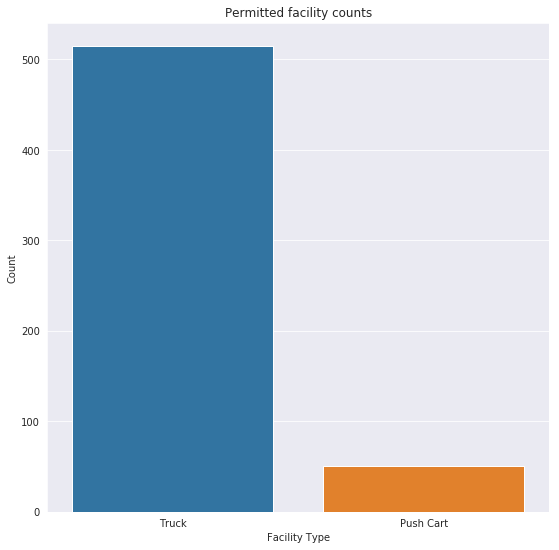

In [8]:
sns.countplot('FacilityType', data=sf)

plt.xlabel('Facility Type')
plt.ylabel('Count')
plt.title('Permitted facility counts')
plt.show()

We want a further breakdown of the data to see who is apply for permits and how many are they applying for. We do this by aggregating the data, counting the number of occurrences a Applicant appears in the dataset.

In [10]:
sf_app = sf.groupby(['Applicant']).size().to_frame('Count')

sf_app.index.name = 'Applicant'
sf_app.reset_index(inplace=True)
sf_app.sort_values(by=['Count'], inplace=True)

A barplot of the number of permits per applicant is displayed below. Because we removed duplicates, this graph also shows the number of locations per applicant. 32% of applicants only have one location and 86% of applicants have less than 10 locations. The top 10 applicants hold 48% of the permits. The applicant with the most permits, May Catering, holds 9% of all permits with 52 total permits.

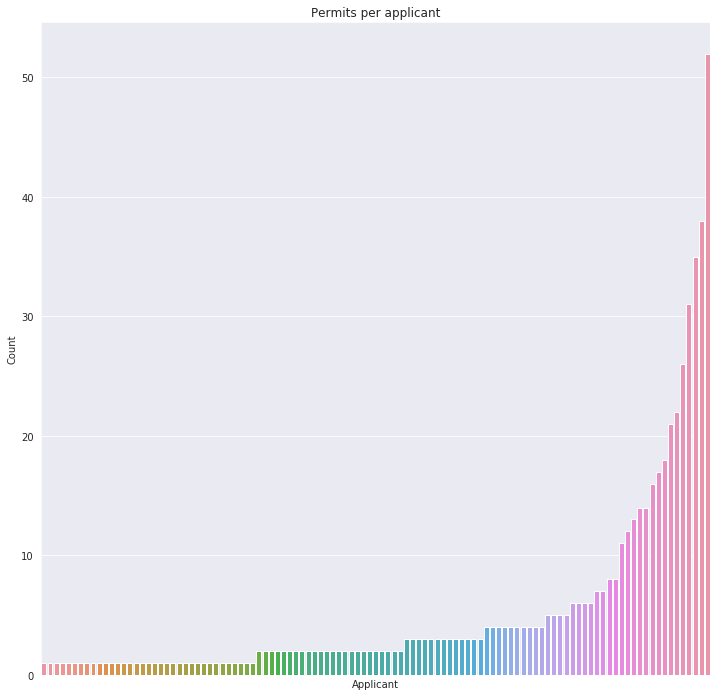

In [13]:
plt.figure(figsize=(12,12))

sns.barplot('Applicant', 'Count', data=sf_app)

plt.xticks([])
plt.xlabel('Applicant')
plt.ylabel('Count')
plt.title('Permits per applicant')

plt.show()

sf_app_breakdown returns the frequency of a number of permits. This gives us an idea of how common it is to have a Applicant to have X number of locations.

In [58]:
sf_app_breakdown = sf_app.groupby('Count').count()

sf_app_breakdown['Percentage'] = sf_app_breakdown['Applicant']/sf_app_breakdown['Applicant'].sum()
sf_app_breakdown.reset_index(inplace=True)
sf_app_breakdown.rename(columns={'Count':'Num_Locations', 'Applicant':'Num_applicant'})

,Num_Locations,Num_applicant,Percentage
0,1,35,0.321101
1,2,24,0.220183
2,3,13,0.119266
3,4,10,0.091743
4,5,4,0.036697
5,6,4,0.036697
6,7,2,0.018349
7,8,2,0.018349
8,11,1,0.009174
9,12,1,0.009174


Looking at which the distribution of the status of mobile food facilities. Ultimately we want to determine if there is a difference between the two facility types, that is if being a food truck means you are more likely to be approved.

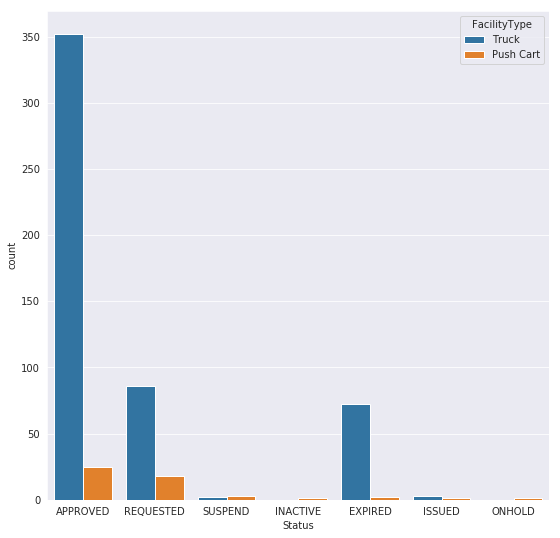

In [14]:
sns.countplot('Status', hue='FacilityType', data=sf)
plt.show()

Preforming a binomial test to see if the proportions below reflect the sample proportions.

In [64]:
facility_counts = sf.groupby('FacilityType').size()
push = facility_counts.iloc[0]/len(sf)
truck = facility_counts.iloc[1]/len(sf)

xtab = pd.crosstab(sf.FacilityType, sf.Status)
approved = xtab.iloc[0][0] + xtab.iloc[1][0]

print('p-value for the binomial test of approved:', binom_test(xtab.iloc[1][0], n=approved, p=truck))

p-value for the binomial test of approved: 0.011714288484693375


We preformed a two-sided binomial test to test if the proportions of each status reflect the proportion in the dataset. We'll use the default $\alpha$ value of 0.05 as the significance level. Because the p-values are less than our significance level we'll reject our $H_{0}$. That is, the number of approved permits for food trucks differs significantly from the expected value.

In [67]:
requested = xtab.iloc[0][1] + xtab.iloc[1][1]

print('p-value for the binomial test of requested:', binom_test(xtab.iloc[1][1], n=requested, p=truck))

p-value for the binomial test of requested: 0.022043648322388094


Running another binomial test with requested gives us another p-value lower than our $\alpha$ value of 0.05, so again we can reject our $H_0$. Therefore, there is a statistically significant difference in the observed number from the expected number.

We can't perform a binomial test on the rest of the categories because we have > 5 observations of each mobile food facility.

# Plot

Splitting the data so we can have differently colored points for push carts and food trucks.

In [7]:
map_push = sf[sf['FacilityType'] == 'Push Cart']
map_truck = sf[sf['FacilityType'] == 'Truck']

In [8]:
#plotly version

mapbox_access_token = 'pk.eyJ1IjoiY2tjaGFuMjAxNCIsImEiOiJjanNudXRtOHUwNTMzNDNydTFnZ2tscjh6In0.UTuKHStBpiCH3UIQ7CbMiw'
data = [
    go.Scattermapbox(
        name='Push Carts',
        lat=map_push['Latitude'], 
        lon=map_push['Longitude'], 
        mode='markers', 
        marker=dict(size=7, opacity=0.6, color='orange'),
        text=map_push['Applicant'],
        hoverinfo='text'
    ),
    go.Scattermapbox(
        name='Food Trucks',
        lat=map_truck['Latitude'],
        lon=map_truck['Longitude'],
        mode='markers',
        marker=dict(size=7, opacity=0.6, color='blue'),
        text=map_truck['Applicant'],
        hoverinfo='text'
    )
    
]

layout = go.Layout(
    title='Map of San Francisco Mobile Food',
    titlefont=dict(
        size=30),
    legend=dict(
        font=dict(
            size=15)),
    autosize=False,
    width=960,
    height=930,
    hovermode='closest',
    mapbox=dict(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=dict(
            lat=37.76,
            lon=-122.4194
        ),
        zoom=11.5,
    ),
)


fig = dict(data=data, layout=layout)
iplot(fig, filename='test1')

# Findings

Looking at the Plotly map we can see that both push carts and food trucks are clustered around areas, particularly in the Financial District, South of Market (SoMa), Bayview District and off of Bayshore Blvd. Most of SF do not have mobile food facilities. Even more than this, mobile food facility seem to be clustered around each other, meaning often times customers have choices. It's rare to find a single mobile food facility.

Most of the push carts are clustered around Union Square and off of Market Street, particularly closer to the Financial District. Both Union Square and Market Street have large amounts of people passing through on a daily basis. Union Square is argubly a tourist area which means lots of potential customers. Market Street is one of the busiest streets in SF, with many people using it to get to work. In addition to cluster together, most areas with push carts lack food trucks. This makes sense given the size of each food facility. Food trucks are significantly bigger than push carts and require a area to park and an additional area for customers to queue. On the otherhand, push carts require far less space and therefore can operate in spaces with a higher density of people, like Union Square.

Food trucks dominate the mobile food scene in SF. They are more expansive than push carts and there are simply more food trucks. The large amounts of food trucks in the Financial District caters to the massive number of people who work in that area. It is not unfair to say that when combined the Financial District and SoMa is the SF skyline, due to the sheer number of skyscrapers. This high density of office workers present a large customer pool for mobile food facilities.

Definitive explanations for the concentrations of food trucks in Bayview District and off of Bayshore Blvd are unknown at this point, but we can speculate. Due to the relatively large amounts of industrial businesses in the Bayview District food trucks may be present there to cater to workers. Bayshore Blvd has a suprising amount of food trucks near it. Like Market Street, we can speculate that it is because it is a very active street with a large amount of pedestrians.

Looking at the map there is a obvious lack of mobile food facilities in large areas. In general, mobile food facilities are clustered around workplaces and are almost non-existent in residential areas. There is a abundance of mobile food facilities in Financial District, SoMa, the Mission District and the BayView District, the places we explored as places of work. In residential neighborhoods like the Richmond District, Sunset District and Daly City there are very few if not not no mobile food facilities.

Overall the clear trend is that density of people seems to be the biggest determinant of location for mobile food facilities.

### Citations

1. Butler, Stephanie. “From Chuck Wagons to Pushcarts: The History of the Food Truck.” History.com, A&E Television Networks, 8 Aug. 2014, www.history.com/news/from-chuck-wagons-to-pushcarts-the-history-of-the-food-truck.
2. Mobile Cuisine, LLC. “The Complete History of American Food Trucks.” Mobile Cuisine | Food Truck, Pop Up & Street Food Coverage, 31 Mar. 2017, mobile-cuisine.com/business/history-of-american-food-trucks/.

### Images
1. https://www.visitmuskogee.com/calendar/food-truck-wars-2/